# Homework 3 - Unsupervised Learning
## Name: Sondre Kongsgaard
## Collaboration group: Anders Vagle, Brage Saether, Morten Lie

In [1]:
import random
import math
import numpy as np
import matplotlib.pyplot as plt

N = 200 # Number of samples

def generate_gaussian_components(N):
    m_1 = [0, 0]
    C_1 = [[2, 0], [0, 1]]
    m_2 = [-2, 1]
    C_2 = [[9.0/8, 7.0/8], [7.0/8, 9.0/8]]
    m_3 = [3, 2]
    C_3 = [[2, 1], [1, 2]]
    
    pi_1 = 1.0/2
    pi_2 = 1.0/6
    
    x = np.zeros((N, 2))
    z = np.zeros((N, 3)) # One-hot encoding
    for i in range(0, N):
        a = random.uniform(0, 1)
        if (a < pi_1):
            #print(1)
            x[i, :] = np.random.multivariate_normal(m_1, C_1, 1)
            z[i][0] = 1
        elif (a < pi_1 + pi_2):
            #print(2)
            x[i, :] = np.random.multivariate_normal(m_2, C_2, 1)
            z[i][1] = 1
        else:
            #print(3)
            x[i, :] = np.random.multivariate_normal(m_3, C_3, 1)
            z[i][2] = 1
    return x, z

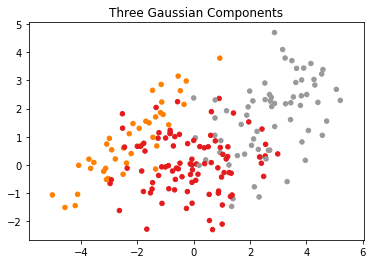

In [2]:
# Three Gaussian components, N samples
x, z = generate_gaussian_components(N)
plt.scatter(x[:, 0], x[:, 1], c=np.where(z)[1], s=20, cmap='Set1')
plt.axis('equal')
plt.title("Three Gaussian Components")
plt.show()

# 1) Implementation of K-means algorithm

In [3]:
def k_means(N, K, C, x):
    m = np.zeros((K, np.size(x, 1)))
    C_new = np.zeros((N, 1))
    while True:
        # Update step
        for j in range(K):
            C_abs = 0
            for i in range(N):
                if C[i] == j+1:
                    C_abs += 1
                    m[j] += x[i]
            if C_abs == 0:
                C_abs = 1
            m[j] /= C_abs
        
        # Assignment step
        for i in range(N):
            min_distance = math.inf
            for j in range(K):
                distance = np.linalg.norm(x[i] - m[j])
                if distance < min_distance:
                    C_new[i] = j+1
                    min_distance = distance
        
        # Check for convergence
        if np.all(C_new == C):
            return m, C_new
        
        C = C_new
        
def mean_squared_error(x, m, C):
    N = len(x)
    K = len(m)
    smse = np.zeros((K,1))
    for i in range(N):
        j = int(C[i])
        smse[j-1] += np.linalg.norm(x[i] - m[j-1])
    return np.sum(smse) / N

In [4]:
n_random_initializations = 5
K_max = 5

m_optimal = np.zeros((K_max, 2, K_max))
C_optimal = np.zeros((N, K_max))

for K in range(2, K_max+1):
    min_mse = math.inf
    for i in range(n_random_initializations):
        C = np.random.randint(1, high=K+1, size=(N, 1))
        m, C = k_means(N, K, C, x)
        mse = mean_squared_error(x, m, C)
        if mse < min_mse:
            m_optimal[0:K, :, K-1] = m
            C_optimal[:, K-1] = C.T
            min_mse = mse
print("K-means complete")

#print("C_optimal: ", C_optimal)
#print("m_optimal: ", m_optimal)

K-means complete


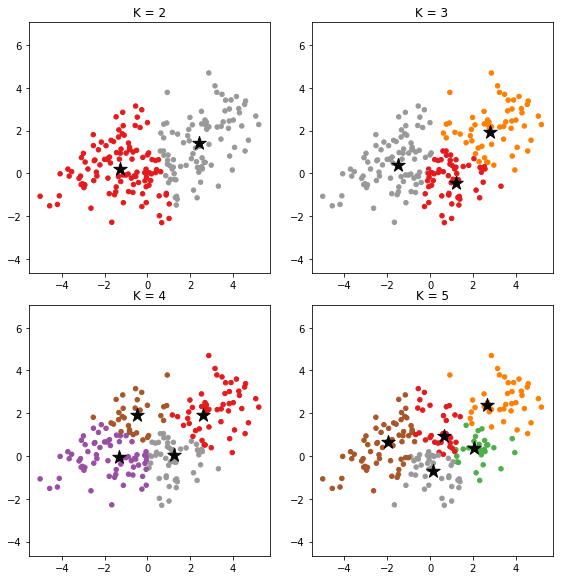

In [5]:
# Compute one-hot encoding 
a = np.zeros((N, K_max, K_max))
for K in range(1, K_max):
    for i in range(N):
        a[i, int(C_optimal[i, K])-1, K] = 1

fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.tight_layout()
for K in range(2, K_max+1):
    row = int(K/2) - 1
    col = (K - 2) % 2
    axes[row, col].scatter(x[:, 0], x[:, 1], c=np.where(a[:,:,K-1])[1], s=20, cmap='Set1')
    axes[row, col].scatter(m_optimal[0:K, :, K-1][:, 0], m_optimal[0:K, :, K-1][:, 1], marker='*', s=200, c='#050505')
    axes[row, col].set_title("K = %s"%K)
    axes[row, col].axis('equal')
plt.show()

In [6]:
def empirical_probabilities():
    empirical_probabilities = np.zeros((3, K_max, K_max))
    for K in range(2, K_max+1):
        for li in range(3):
            for j in range(K):
                num_a = 0
                num_z = 0
                for i in range(N):
                    if z[i, li] == 1:
                        num_z += 1
                        if a[i, j, K-1] == 1:
                            num_a += 1
                empirical_probabilities[li, j, K-1] = num_a / num_z
    return empirical_probabilities

print(empirical_probabilities())

[[[0.         0.72826087 0.44565217 0.05434783 0.19565217]
  [0.         0.27173913 0.07608696 0.44565217 0.10869565]
  [0.         0.         0.47826087 0.14130435 0.01086957]
  [0.         0.         0.         0.35869565 0.29347826]
  [0.         0.         0.         0.         0.39130435]]

 [[0.         0.97560976 0.         0.         0.09756098]
  [0.         0.02439024 0.02439024 0.65853659 0.        ]
  [0.         0.         0.97560976 0.34146341 0.02439024]
  [0.         0.         0.         0.         0.87804878]
  [0.         0.         0.         0.         0.        ]]

 [[0.         0.05970149 0.23880597 0.68656716 0.13432836]
  [0.         0.94029851 0.73134328 0.         0.25373134]
  [0.         0.         0.02985075 0.05970149 0.56716418]
  [0.         0.         0.         0.25373134 0.        ]
  [0.         0.         0.         0.         0.04477612]]]


Read the table above as for each _true_ class (e.g. 3), if K is e.g. 2, the conditional probabilities for each assigned class are printed in the second column in the third 2D table.

# 2) Implementation of EM algorithm

In [7]:
from scipy.stats import multivariate_normal

def EM(m, C, pi, N, K, x, max_iter=10):
    for iter in range(max_iter):
        # Assignment step (E step)
        p_k = np.zeros((N, K))
        for i in range(N):
            pi_norm_distribution = np.zeros((K,1))
            for j in range(K):
                mvn = multivariate_normal(m[j], C[j])
                pi_norm_distribution[j] = pi[j] * mvn.pdf(x[i, :])
            for j in range(K):
                p_k[i, j] = pi_norm_distribution[j] / np.sum(pi_norm_distribution)
            
        # Update step (M step)
        for j in range(K):
            num = 0
            for i in range(N):
                num += p_k[i, j] * x[i, :]
            m[j] = num / np.sum(p_k[:, j])
            
            num = 0
            for i in range(N):
                num += p_k[i, j] * np.outer(x[i, :] - m[j], x[i, :] - m[j])
            C[j] = num / np.sum(p_k[:, j])
            
            pi[j] = np.sum(p_k[:, j]) / N

    return m, C, pi, p_k
        
m_EM = np.zeros((K_max, 2, K_max))
C_EM = np.zeros((K_max, K_max, 2, 2))
p_k_EM = np.zeros((K_max, N, K_max))
for K in range(2, K_max+1):
    C_EM_initial = np.repeat(np.eye(2)[np.newaxis, :, :], K, axis=0)
    m_EM_initial = m_optimal[0:K, :, K-1]
    pi_EM_initial = 1/K * np.ones((K,1))

    m_EM[0:K, :, K-1], C_EM[K-1, 0:K], pi_EM, p_k_EM[K-1, :, 0:K] = EM(m_EM_initial, C_EM_initial, pi_EM_initial, N, K, x)

print("EM complete")

EM complete


In [8]:
p_k_average = np.zeros((K_max, 3, K_max))
for K in range(2, K_max+1):
    n = np.zeros(3)
    for i in range(N):
        for li in range(3):
            if z[i, li] == 1:
                p_k_average[K-1, li, K-1] += p_k_EM[K-1, i, K-1]
                n[li] += 1
    for li in range(3):
        p_k_average[K-1, li, K-1] /= n[li]

print(p_k_average)
for i in range(3):
    print(np.sum(p_k_average[i]))

[[[0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]]

 [[0.         0.29910206 0.         0.         0.        ]
  [0.         0.00389527 0.         0.         0.        ]
  [0.         0.83013714 0.         0.         0.        ]]

 [[0.         0.         0.35827418 0.         0.        ]
  [0.         0.         0.97910037 0.         0.        ]
  [0.         0.         0.06607454 0.         0.        ]]

 [[0.         0.         0.         0.46314199 0.        ]
  [0.         0.         0.         0.0067737  0.        ]
  [0.         0.         0.         0.28435558 0.        ]]

 [[0.         0.         0.         0.         0.44052577]
  [0.         0.         0.         0.         0.05771732]
  [0.         0.         0.         0.         0.07302884]]]
0.0
1.1331344639705554
1.403449086925682


# 3) Geometrically find visualization of means and covariances as a contour plot

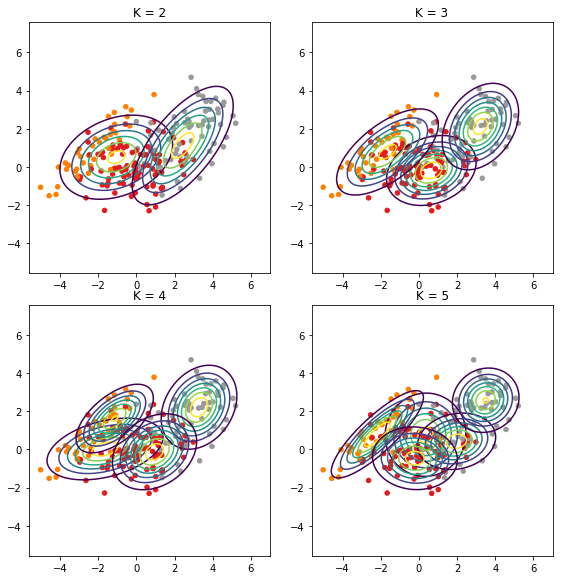

In [9]:
def multivariate_gaussian(pos, mu, Sigma):
    """Return the multivariate Gaussian distribution on array pos.

    pos is an array constructed by packing the meshed arrays of variables
    x_1, x_2, x_3, ..., x_k into its _last_ dimension.
    """

    n = mu.shape[0]
    Sigma_det = np.linalg.det(Sigma)
    Sigma_inv = np.linalg.inv(Sigma)
    N = np.sqrt((2*np.pi)**n * Sigma_det)
    # This einsum call calculates (x-mu)T.Sigma-1.(x-mu) in a vectorized
    # way across all the input variables.
    fac = np.einsum('...k,kl,...l->...', pos-mu, Sigma_inv, pos-mu)

    return np.exp(-fac / 2) / N

X = np.linspace(-5, 7, N)
Y = np.linspace(-5, 7, N)
X, Y = np.meshgrid(X, Y)

# Pack X and Y into a single 3-dimensional array
pos = np.empty(X.shape + (2,))
pos[:, :, 0] = X
pos[:, :, 1] = Y

fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.tight_layout()
for K in range(2, K_max+1):
    row = int(K/2) - 1
    col = (K - 2) % 2
    axes[row, col].scatter(x[:, 0], x[:, 1], c=np.where(z)[1], s=20, cmap='Set1')
    for j in range(K):
        Z = multivariate_gaussian(pos, m_EM[j,:,K-1], C_EM[K-1, j])
        axes[row, col].contour(X, Y, Z)
    axes[row, col].set_title("K = %s"%K)
    axes[row, col].axis('equal')
plt.show()

Further experiments will be done with higher dimensional data
# 4) Generate a random vector $\mathbf{u}$ in $d$ dimensions

In [21]:
d = 30

def generate_random_vector(d):
    u = np.zeros((d, 1)) 
    P_1 = 2.0/3
    P_2 = 1.0/6
    for i in range(d):
        a = random.uniform(0, 1)
        if (a < P_1):
            u[i] = 0
        elif (a < P_1 + P_2):
            u[i] = 1
        else:
            u[i] = -1
    return u

u = np.zeros((d, 6))
for j in range(6):
    u[:,j] = generate_random_vector(d).T
print(u) # Manually inspect that the vectors u_j, j=1,...,7 are quasi-orthogonal

[[-1.  0. -1.  0. -1.  0.]
 [-1.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0. -1.]
 [ 0.  0.  1.  0.  0.  0.]
 [ 0.  1.  0. -1. -1.  0.]
 [ 0.  0.  1.  0.  0.  1.]
 [-1.  0. -1.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  1.]
 [ 0.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  1. -1.  0.]
 [-1.  1.  0. -1.  0.  0.]
 [ 0.  0.  1. -1.  1.  0.]
 [ 0. -1.  0.  1.  0.  0.]
 [ 0.  0. -1.  0.  1.  0.]
 [ 1.  0. -1.  0.  0.  0.]
 [ 0.  0.  0. -1.  0. -1.]
 [ 0.  1.  0.  0. -1.  0.]
 [-1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.]
 [ 0. -1.  0.  1.  1.  0.]
 [ 0.  0.  0.  0. -1.  0.]
 [-1.  0. -1.  0. -1.  0.]
 [ 1.  1.  0.  0.  0.  0.]
 [ 1.  1.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.]
 [ 1. -1.  0.  0.  1.  0.]
 [ 0.  0.  0.  0. -1.  0.]
 [-1.  0.  1.  0.  0.  0.]
 [ 0. -1.  0.  0.  0.  0.]]


# 5) Generate $d$-dimensional  data samples for a Gaussian mixture distribution with 3 equiprobable components

In [22]:
def generate_d_dimensional_gaussian_components(N, d, u):

    pi_1 = 1.0 / 3
    pi_2 = 1.0 / 3

    sigma_squared = 0.01

    x = np.zeros((N, d))
    z = np.zeros((N, 3)) # One-hot encoding
    for i in range(N):
        Z_1 = np.random.normal(0, 1, 1)
        Z_2 = np.random.normal(0, 1, 1)
        noise = np.random.multivariate_normal(np.zeros(d), sigma_squared*np.eye(d), 1)

        a = random.uniform(0, 1)
        if (a < pi_1):
            x[i, :] = u[:, 0] + Z_1*u[:, 1] + Z_2*u[:, 2] + noise
            z[i][0] = 1
        elif (a < pi_1 + pi_2):
            x[i, :] = 2*u[:, 3] + math.sqrt(2)*Z_1*u[:, 4] + Z_2*u[:, 5] + noise
            z[i][1] = 1
        else:
            x[i, :] = math.sqrt(2)*u[:, 5] + Z_1*(u[:, 0] + u[:, 1]) + 1.0/math.sqrt(2)*Z_2*u[:,4] + noise
            z[i][2] = 1
    return x, z

# 6) Generate N data samples from the preceding model, and classify with k-means

In [23]:
N = 200 # TODO: To be determined
x, z = generate_d_dimensional_gaussian_components(N, d, u)

In [24]:
m_optimal = np.zeros((K_max, np.size(x, 1), K_max))
C_optimal = np.zeros((N, K_max))

for K in range(2, K_max+1):
    min_mse = math.inf
    for i in range(n_random_initializations):
        C = np.random.randint(1, high=K+1, size=(N, 1))
        m, C = k_means(N, K, C, x)
        mse = mean_squared_error(x, m, C)
        if mse < min_mse:
            m_optimal[0:K, :, K-1] = m
            C_optimal[:, K-1] = C.T
            min_mse = mse
print("K-means complete")

K-means complete


In [25]:
# Compute one-hot encoding 
a = np.zeros((N, K_max, K_max))
for K in range(1, K_max):
    for i in range(N):
        a[i, int(C_optimal[i, K])-1, K] = 1
        
#print(a)

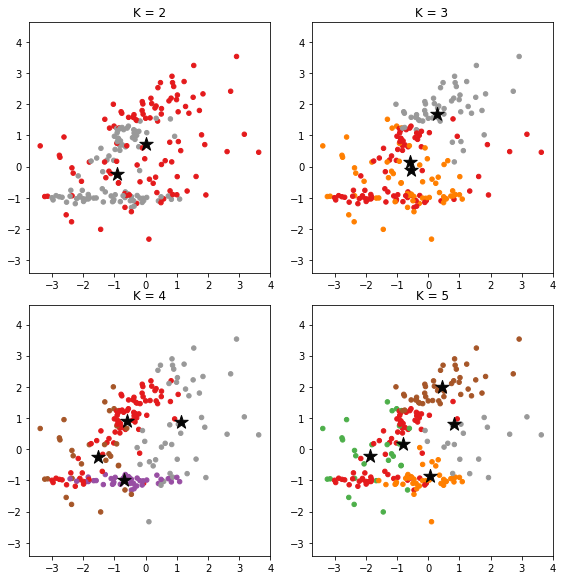

In [26]:
fig, axes = plt.subplots(2, 2, figsize=(8,8))
fig.tight_layout()
for K in range(2, K_max+1):
    row = int(K/2) - 1
    col = (K - 2) % 2
    axes[row, col].scatter(x[:, 0], x[:, 1], c=np.where(a[:,:,K-1])[1], s=20, cmap='Set1')
    axes[row, col].scatter(m_optimal[0:K, :, K-1][:, 0], m_optimal[0:K, :, K-1][:, 1], marker='*', s=200, c='#050505')
    axes[row, col].set_title("K = %s"%K)
    axes[row, col].axis('equal')
plt.show()

In [27]:
print(empirical_probabilities())

[[[0.         0.09836066 0.68852459 0.27868852 0.49180328]
  [0.         0.90163934 0.31147541 0.72131148 0.01639344]
  [0.         0.         0.         0.         0.49180328]
  [0.         0.         0.         0.         0.        ]
  [0.         0.         0.         0.         0.        ]]

 [[0.         1.         0.12280702 0.         0.        ]
  [0.         0.         0.78947368 0.         0.49122807]
  [0.         0.         0.0877193  0.50877193 0.19298246]
  [0.         0.         0.         0.49122807 0.        ]
  [0.         0.         0.         0.         0.31578947]]

 [[0.         0.5        0.42682927 0.7804878  0.45121951]
  [0.         0.5        0.         0.         0.        ]
  [0.         0.         0.57317073 0.01219512 0.        ]
  [0.         0.         0.         0.20731707 0.54878049]
  [0.         0.         0.         0.         0.        ]]]


# 7) Geometric insight into how the cluster centers found by *K*-means relate to the vectors ${\mathbf{\{u\}}_j}$ in the model

In [28]:
print(m_optimal)

[[[ 0.00000000e+00  5.00381981e-03 -5.88208925e-01 -6.02869550e-01
   -8.13518906e-01]
  [ 0.00000000e+00  7.23015015e-01  1.47639569e-01  8.92318898e-01
    1.54781922e-01]
  [ 0.00000000e+00 -4.77553574e-01 -7.39751183e-01 -1.19871882e+00
   -8.52142868e-01]
  [ 0.00000000e+00 -3.51150536e-02  1.81532137e-01  1.75839910e-01
    2.25607231e-01]
  [ 0.00000000e+00 -1.72640668e+00  4.53440986e-01  1.56372821e-01
    6.14147179e-01]
  [ 0.00000000e+00  4.43883460e-01  9.62102176e-01  1.38521093e+00
    1.11321057e+00]
  [ 0.00000000e+00  5.16549794e-01 -1.03206244e+00 -3.37974552e-01
   -1.08997714e+00]
  [ 0.00000000e+00  2.41983489e-01  1.37509477e+00  1.48773921e+00
    1.58911423e+00]
  [ 0.00000000e+00 -3.63832410e-01  5.94061370e-01  4.62222502e-01
    8.55858364e-01]
  [ 0.00000000e+00  8.93146969e-01  4.23245021e-01 -9.65148653e-02
    3.32130565e-01]
  [ 0.00000000e+00 -1.22788245e+00 -3.93382931e-01 -1.86825091e-02
   -2.67366366e-01]
  [ 0.00000000e+00 -9.12455107e-01 -2.21137

For K = 3, the optimal cluster centers should be close to the sum of the $\mathbf{u}_j$, where $j$ is in the set as given by the equations in problem 6).

# 8) *d*-dimensional EM

In [18]:
def EM(m, C, pi, N, K, x, max_iter=100):
    for iter in range(max_iter):
        # Assignment step (E step)
        p_k = np.zeros((N, K))
        for i in range(N):
            pi_norm_distribution = np.zeros((K,1))
            for j in range(K):
                mvn = multivariate_normal(m[j], C[j])
                pi_norm_distribution[j] = pi[j] * mvn.pdf(x[i, :])
            for j in range(K):
                p_k[i, j] = pi_norm_distribution[j] / np.sum(pi_norm_distribution)
            
        # Update step (M step)
        for j in range(K):
            num = 0
            for i in range(N):
                num += p_k[i, j] * x[i, :]
            m[j] = num / np.sum(p_k[:, j])
            
            num = 0
            for i in range(N):
                num += p_k[i, j] * np.outer(x[i, :] - m[j], x[i, :] - m[j])
            C[j] = num / np.sum(p_k[:, j])
            
            pi[j] = np.sum(p_k[:, j]) / N

    return m, C, pi, p_k

m_EM = np.zeros((K_max, d, K_max))
C_EM = np.zeros((K_max, K_max, d, d))
p_k_EM = np.zeros((K_max, N, K_max))
for K in range(2, K_max+1):
    C_EM_initial = np.repeat(np.eye(np.size(x, 1))[np.newaxis, :, :], K, axis=0)
    m_EM_initial = m_optimal[0:K, :, K-1]
    pi_EM_initial = 1/K * np.ones((K,1))

    #m_EM[0:K, :, K-1], C_EM[K-1, 0:K], pi_EM, p_k_EM[K-1, :, 0:K] = EM(m_EM_initial, C_EM_initial, pi_EM_initial, N, K, x)
    m_EM[0:K, :, K-1], C_EM[K-1, 0:K], pi_EM, p_k_EM[K-1, :, 0:K] = EM(m_EM_initial, C_EM_initial, pi_EM_initial, N, K, x, max_iter = 2)
    
print("EM complete")

EM complete


In [19]:
#print(np.size(C_EM, 0))
for K in range(1, K_max):
    w, v = np.linalg.eig(C_EM[K])
    print("K =", K+1)
    print(v)

K = 2
[[[ 0.9476083  -0.31943467]
  [ 0.31943467  0.9476083 ]]

 [[ 0.97338413 -0.22917969]
  [ 0.22917969  0.97338413]]

 [[ 1.          0.        ]
  [ 0.          1.        ]]

 [[ 1.          0.        ]
  [ 0.          1.        ]]

 [[ 1.          0.        ]
  [ 0.          1.        ]]]
K = 3
[[[ 0.95361541 -0.30102767]
  [ 0.30102767  0.95361541]]

 [[ 0.89754974 -0.44091321]
  [ 0.44091321  0.89754974]]

 [[ 0.9861057  -0.16611908]
  [ 0.16611908  0.9861057 ]]

 [[ 1.          0.        ]
  [ 0.          1.        ]]

 [[ 1.          0.        ]
  [ 0.          1.        ]]]
K = 4
[[[ 0.88790362 -0.46002952]
  [ 0.46002952  0.88790362]]

 [[ 0.9895284  -0.14433829]
  [ 0.14433829  0.9895284 ]]

 [[ 0.86654578 -0.49909759]
  [ 0.49909759  0.86654578]]

 [[ 0.98716354 -0.1597127 ]
  [ 0.1597127   0.98716354]]

 [[ 1.          0.        ]
  [ 0.          1.        ]]]
K = 5
[[[ 0.98371466 -0.17973722]
  [ 0.17973722  0.98371466]]

 [[ 0.99976953  0.02146818]
  [-0.02146818  0.99

# 9) Deterministic annealing
Implementation:
- Initialization
- Cooling
- Check for termination
- Quenching